# **Methods for WWA synthesis & plotting**

- some modifications still needed to handle logs

In [308]:
import pandas as pd
import numpy as np
import re
from scipy.optimize import brent
from math import log, exp

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [80]:
df_in = pd.read_table("minisynth_in.txt", skiprows = 1, sep = " ", names = ["y0","y1","est", "lower", "upper", "ci", "model", "m2", "m3"])

obs_in = df_in.iloc[:3]
models_in = df_in.iloc[3:]

## **Methods**

In [81]:
def model_mean(models, sig_mod = 0):

    # calculate weight for each model (based on width of confidence interval)
    w = 1/((models.upper - models.lower)**2 + (2*sig_mod)**2)
    w1 = sum(w)
    
    s1 = sum(models.est * w) / w1
    
    # inner bounds (coloured box, internal variability only)
    lower = np.sqrt(sum((w*(models.est - models.lower))**2)) / w1
    upper = np.sqrt(sum((w*(models.est - models.upper))**2)) / w1
    
    # outer bounds(white box, includes representation error via sig_mod)
    l_wb = np.sqrt(lower**2 + sig_mod**2)
    u_wb = np.sqrt(upper**2 + sig_mod**2)
    
    return pd.Series({"est" : s1,
                      "lower" : s1 - lower,
                      "upper" : s1 + upper,
                      "l_wb" : s1 - l_wb,
                      "u_wb" : s1 + u_wb})
    

In [82]:
def model_chi2(models_in, sig_mod = 0):

    # get best estimate using current value of sig_mod
    s1 = model_mean(models_in, sig_mod)["est"]
    
    # identify whether to use upper or lower bound to compute chi^2
    bounds = pd.Series([r.lower if r.est > s1 else r.upper for k,r in models_in.iterrows()], index=models_in.index)
    
    # compute chi^2
    chi2 = sum((models_in.est - s1)**2 / ((models_in.est - bounds)**2 + sig_mod**2))
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    
    return chi2

In [330]:
def synthesis(obs_in, models_in, cx_format = False, take_logs = False):

    if take_logs:
        obs_in, models_in = [pd.merge(df[[c for c in df.columns if not c in ["est", "lower", "upper"]]],
                                      np.log(df[["est", "lower", "upper"]]), left_index = True, right_index = True)
                             for df in [obs_in, models_in]]
    
    # and now, the actual synthesis
    
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## OBSERVATIONS
    # get mean of intervals to estimate natural variability component
    obs_synth = obs_in[["est", "lower", "upper"]].mean(axis = 0)
    
    # compute representation error from scatter of mean
    nobs = len(obs_in)

    if nobs == 1:
        # can't estimate representation uncertainty, so just use the lower & upper bounds from the bootstrap
        sig_obs = 0
        obs_out = pd.merge(obs_in, pd.DataFrame({"l_wb" : obs_in.lower, "u_wb" : obs_in.upper}).set_index(obs_in.index),
                          left_index = True, right_index = True)
        
    else:
        # add representation error to observations
        sig_obs = 2 * np.sqrt(sum((obs_in.est - obs_synth["est"])**2) / (nobs-1))
    
        obs_out = pd.merge(obs_in, 
                          pd.DataFrame({"l_wb" : obs_in.est - np.sqrt((obs_in.est - obs_in.lower)**2 + sig_obs**2),
                                        "u_wb" : obs_in.est + np.sqrt((obs_in.est - obs_in.upper)**2 + sig_obs**2)}).set_index(obs_in.index),
                          left_index = True, right_index = True)
        
    # add representation error to model synthesis
    obs_synth["l_wb"] = obs_synth.est - np.sqrt((obs_synth.est - obs_synth.lower)**2 + sig_obs**2)
    obs_synth["u_wb"] = obs_synth.est + np.sqrt((obs_synth.est - obs_synth.upper)**2 + sig_obs**2)
    
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## MODELS
    
    # estimate the ratio between 
    chi2 = model_chi2(models_in, sig_mod = 0)
    mdof = len(models_in) - 1
    
    # numerically optimise sig_mod such that chi^2/dof = 1        
    ## NB. no bounds are provided for the search, unlike in the original Fortran code
    sigmod = brent(lambda x : (model_chi2(models_in, sig_mod = x) - mdof)**2)
    
    # store model weights for later reference
    model_weights = 1/((models_in.upper - models_in.lower)**2 + (2*sigmod)**2)
    model_weights = model_weights / sum(model_weights)
    
    # synthesise the models
    models_synth = model_mean(models_in, sig_mod = sigmod)
    
    # add representation error to individual models
    models_out = pd.merge(models_in, 
                      pd.DataFrame({"l_wb" : models_in.est - np.sqrt((models_in.est - models_in.lower)**2 + sigmod**2),
                                    "u_wb" : models_in.est + np.sqrt((models_in.est - models_in.upper)**2 + sigmod**2)}).set_index(models_in.index),
                      left_index = True, right_index = True)
    
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## COMBINE MODELS AND OBSERVATIONS
    
    # weighted mean of models & obs (weighted by total precision of each estimate)
    w_obs = 1 / np.sqrt((obs_synth["u_wb"] - obs_synth["l_wb"]))
    w_mod = 1 / np.sqrt((models_synth["u_wb"] - models_synth["l_wb"]))
    tw = w_obs + w_mod

    wmean = (w_obs * obs_synth["est"] + w_mod * models_synth["est"]) / (w_obs + w_mod)
    
    # get weighted intervals above & below best estimate
    bounds = np.sqrt(w_obs*(obs_synth.est - obs_synth)**2 + w_mod*(models_synth.est - models_synth)**2) / (w_obs + w_mod)
    
    # add weighted intervals to weighted mean
    synth_w = wmean + (bounds * np.sign(obs_synth - obs_synth.est))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # unweighted mean of observations & models
    umean = (obs_synth.est + models_synth.est) / 2 
    
    ubounds = np.sqrt((obs_synth.est - obs_synth)**2 + (models_synth.est - models_synth)**2) / 2
    synth_uw = umean + (ubounds * np.sign(obs_synth - obs_synth.est))
    
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## RETURN RESULTS
    
    # assign groups & labels for easier plotting later
    obs_out = obs_out.assign(group = "obs", weight = 1/nobs)
    obs_synth = pd.DataFrame(pd.concat([pd.Series({"model" : "Observations", "group" : "obs_synth", "weight" : w_obs / tw}), obs_synth])).transpose()
    models_out = models_out.assign(group = "models", weight = model_weights)
    models_synth = pd.DataFrame(pd.concat([pd.Series({"model" : "Models", "group" : "models_synth", "weight" : w_mod / tw}), models_synth])).transpose()
    synth_w = pd.DataFrame(pd.concat([pd.Series({"model" : "Synthesis", "group" : "synthesis"}), synth_w])).transpose()
    synth_uw = pd.DataFrame(pd.concat([pd.Series({"model" : "Unweighted", "group" : "synth_uw"}), synth_uw])).transpose()
    
    if cx_format:
        # to replicate standard climate explorer plots, need to modify to correct format
        # only outer bounds showing total variance are plotted
        obs_synth[["lower", "upper"]] = obs_synth[["l_wb", "u_wb"]]
        models_synth[["lower", "upper"]] = models_synth[["l_wb", "u_wb"]]

        # unweighted synthesis provides outer bounds for main synthesis, doesn't appear as a separate row
        synth_w[["l_wb", "u_wb"]] = synth_uw[["l_wb", "u_wb"]]
        synth_res = pd.concat([obs_out, obs_synth, models_out, models_synth, synth_w])
        
    else:
        # output everything together
        synth_res = pd.concat([obs_out, obs_synth, models_out, models_synth, synth_w, synth_uw])

    # if only one set of observations, remove the synthesis
    if nobs == 1: 
        synth_res = synth_res.loc[synth_res.group != "obs_synth"]
        synth_res.loc[synth_res.group == "obs", "group"] = "obs_synth"
        
    # clean up indexing
    synth_res = synth_res.reset_index(drop = True)

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## REVERSE THE LOG-TRANSFORMATION, IF NECESSARY
    if take_logs:
        synth_res = pd.merge(synth_res[[c for c in synth_res.columns if not c in ["est", "lower", "upper", "l_wb", "u_wb"]]],
                             np.exp(synth_res[["est", "lower", "upper", "l_wb", "u_wb"]].apply(pd.to_numeric, errors='coerce')), left_index = True, right_index = True)
        sig_obs = np.exp(sig_obs)
        sigmod = np.exp(sigmod)
        
    return {"sig_rep" : sig_obs, "chi2dof" : chi2 / mdof, "sig_mrep" : sigmod, "df" : synth_res, "logged" : True}

## **Plotting**

In [328]:
def plot_synthesis(synth, ax = None, logged = False, add_space = True):

    # should also check in case df is passed directly
    df = synth["df"]
    
    # print results rounded to 3sf
    # [print(v+": ", round(synth[v], -int(np.floor(np.log(np.abs(synth[v]))))+2)) for v in ["sig_rep", "chi2dof", "sig_mrep"]]
    
    # specify colours to be used
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "models_synth" : "red",
             "synthesis" : "magenta",
             "synth_uw" : "slateblue",
             "" : "white"}
    
    # add dummy rows for nicer spacing
    # if add_space:
    #     df = df.reset_index(drop=True)
    #     df.loc[list(df.model).index("Observations")+0.5] = ["" if c in ["group", "model"] else np.NaN for c in df.columns]
    #     df.loc[list(df.model).index("Models")+0.5] = ["" if c in ["group", "model"] else np.NaN for c in df.columns]
    #     df = df.sort_index().reset_index(drop=True)
    #     df

    # create a new figure if no axis is passed
    if not ax: fig, ax = plt.subplots(dpi = 100)

    # gridlines & ticks
    ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)
    ax.set_yticks(range(0, -len(df), -1))
    ax.set_yticklabels(df.model)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k", zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", zorder = -99)
        
    for k in range(len(df)):
        
        r = df.iloc[k]
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "w", lw = 1.5))
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.group], alpha = 0.5 + 0.5*("synth" in r.group)))
    
        ax.plot(r.est, -k, color = "k", marker = "v")  

0.6590102289822608 1.1177703499930889
0.10540925533894598 0.12412101900905712


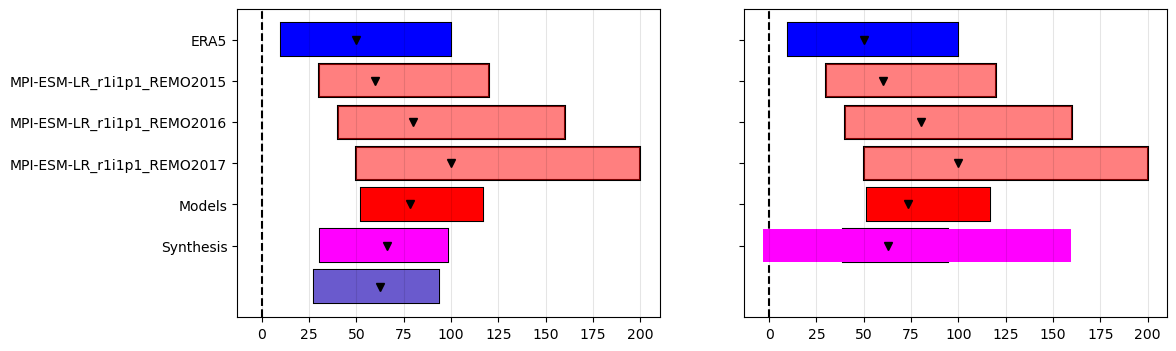

In [331]:
fig, axs = plt.subplots(ncols = 2, sharey = True, sharex = True, figsize = (12,4))

# can either print with the weighted & unweighted synthesis split out, and natural/representation uncertainty split
plot_synthesis(synthesis(obs_in, models_in, cx_format = False, take_logs = True), ax = axs[0])

# or use the format that comes out of the Climate Explorer
plot_synthesis(synthesis(obs_in, models_in, cx_format = True), ax = axs[1])

In [324]:
synthesis

<function __main__.synthesis(obs_in, models_in, cx_format=False, take_logs=False)>

### **Quickly plot Climate Explorer output**

In [312]:
def plot_from_cx(fnm, ax = None, logged = False):
    
    df = pd.read_fwf(fnm, comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                     names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")
    
    if not ax: fig, ax = plt.subplots(dpi = 100)
    
    gcols = ["blue", "blue", "red", "red", "magenta"]
    galpha = [0.5,1,0.5,1,1]
    
    ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)
            
    for k in range(len(df)):
        
        r = df.iloc[k]
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "w", lw = 1.5))
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[int(r.group)-1], alpha = galpha[int(r.group)-1]))
    
        ax.plot(r.est, -k, color = "k", marker = "v")  
    
    if logged:
        ax.set_xscale('log') 
        ax.axvline(1, ls = "--", color = "k", lw = 1, zorder = -99)
    else:
        ax.axvline(0, ls = "--", color = "k", lw = 1, zorder = -99)
    
    ax.set_yticks(range(0, -len(df), -1))
    ax.set_yticklabels([re.sub('"', '', r).strip() for r in df.index])

## **Modification for logged data**

In [313]:
synth_fnm = "toy"

df_in = pd.read_table(synth_fnm+"_in.txt", skiprows = 1, sep = " ", names = ["y0","y1","est", "lower", "upper", "ci", "model", "m2", "m3"])

obs_in = df_in.iloc[:1]
models_in = df_in.iloc[2:]

df_out = pd.read_fwf(synth_fnm+"_out.txt", comment = "#", header = None, widths = [5,5,12,12,12,12,12,4,99], 
                     names = ["y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model"], index_col = "model")

In [314]:
res = synthesis(obs_in, models_in, cx_format = True, take_logs = True)

TypeError: must be real number, not DataFrame

In [ ]:
fig, axs = plt.subplots(ncols = 2, sharey = True, sharex = True, figsize = (12,4))

plot_synthesis(res, logged = True, ax = axs[0], add_space = False)
axs[0].set_title("My attempt")

plot_from_cx(synth_fnm+"_out.txt", logged = True, ax = axs[1])
axs[1].set_title("Output from Climate Explorer")

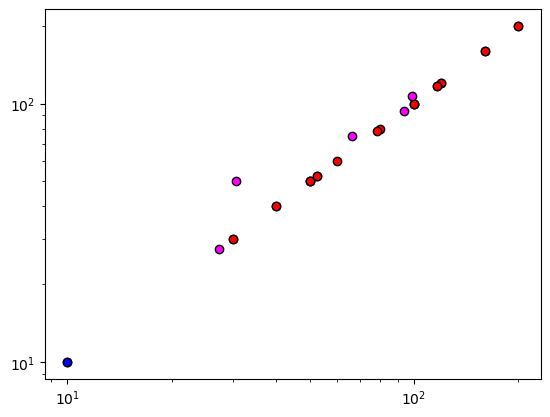

In [218]:
gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "models_synth" : "red",
             "synthesis" : "magenta",
             "synth_uw" : "slateblue",
             "" : "white"}

synth_res = res["df"]
plt.scatter(synth_res.loc[:,["est", "lower", "upper", "l_wb", "u_wb"]],
            df_out.loc[:,["est", "lower", "upper", "l_wb", "u_wb"]], color = "w", zorder = -99)
ax = plt.gca()
for g in ["obs", "obs_synth", "models", "models_synth", "synthesis"]:
    ax.scatter(synth_res.loc[synth_res.group == g, ["est", "lower", "upper", "l_wb", "u_wb"]],
                df_out.loc[df_out.group == ["obs", "obs_synth", "models", "models_synth", "synthesis"].index(g)+1, ["est", "lower", "upper", "l_wb", "u_wb"]],
    facecolor = gcols[g], edgecolor = "k")
ax.set_xscale('log') 
ax.set_yscale('log') 

## **Check possible rounding error in synthesis**

In [345]:
# weighted mean of models & obs (weighted by total precision of each estimate)
obs_synth = synth_res.loc[synth_res.group == "obs_synth", ["est", "lower", "upper", "l_wb", "u_wb"]].squeeze()
models_synth = synth_res.loc[synth_res.group == "models_synth", ["est", "lower", "upper", "l_wb", "u_wb"]].squeeze()

def qsynth(o, m, dp = None):

    o, m = [np.log(x) for x in [o,m]]

    print((o["u_wb"] - o["l_wb"]))

    w_obs = (o["u_wb"] - o["l_wb"])^(-2)
    w_mod = (m["u_wb"] - m["l_wb"])^(-2)

    tw = w_obs + w_mod
    
    wmean = (w_obs * o["est"] + w_mod * m["est"]) / (w_obs + w_mod)
    
    # get weighted intervals above & below best estimate
    bounds = np.sqrt(w_obs*(o.est - o)**2 + w_mod*(m.est - m)**2) / (w_obs + w_mod)
    
    # add weighted intervals to weighted mean
    synth_w = wmean + (bounds * np.sign(o - o.est))

    if dp is not None:
        synth_w = round(synth_w, dp)

    return np.exp(synth_w)

qsynth(obs_synth, models_synth)

2.302585092994046


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [335]:
models_synth

est       78.297353
lower     52.474382
upper    116.827969
l_wb      52.474382
u_wb     116.827969
Name: 4, dtype: float64

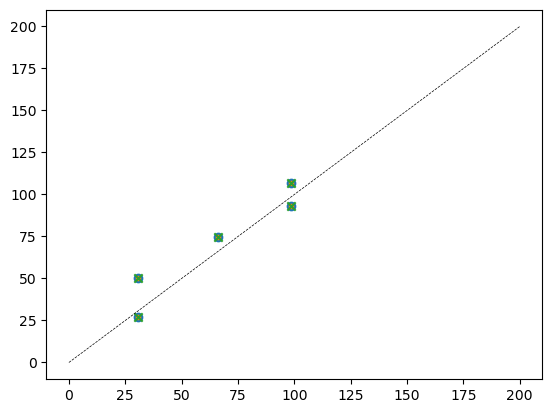

In [300]:
cx_synth = df_out.loc[df_out.group == 5, ["est", "lower", "upper", "l_wb", "u_wb"]]

synth_exact = qsynth(obs_synth, models_synth)
synth_10dp = qsynth(obs_synth, models_synth, dp = 10)
synth_5dp = qsynth(obs_synth, models_synth, dp = 5)

plt.scatter(synth_exact, cx_synth)
plt.scatter(synth_10dp, cx_synth, color = "tab:orange", marker = ".")
plt.scatter(synth_5dp, cx_synth, color = "tab:green", marker = "x")

ax = plt.gca()
# ax.set_xscale('log') 
# ax.set_yscale('log') 
ax.plot((0,200), (0,200), color = "k", lw = 0.5, ls = "--")



In [306]:
res

{'sig_rep': 1.0,
 'chi2dof': 0.5460080740467956,
 'sig_mrep': 0.9999999998195588,
 'df':        y0      y1    ci                       model   m2  m3         group  \
 0  1900.0  2020.0  95.0                        ERA5  NaN NaN     obs_synth   
 1  1900.0  2020.0  95.0  MPI-ESM-LR_r1i1p1_REMO2015   () NaN        models   
 2  1900.0  2020.0  95.0  MPI-ESM-LR_r1i1p1_REMO2016   () NaN        models   
 3  1900.0  2020.0  95.0  MPI-ESM-LR_r1i1p1_REMO2017   () NaN        models   
 4     NaN     NaN   NaN                      Models  NaN NaN  models_synth   
 5     NaN     NaN   NaN                   Synthesis  NaN NaN     synthesis   
 
      weight         est      lower       upper       l_wb        u_wb  
 0       1.0   50.000000  10.000000  100.000000  10.000000  100.000000  
 1  0.333333   60.000000  30.000000  120.000000  30.000000  120.000000  
 2  0.333333   80.000000  40.000000  160.000000  40.000000  160.000000  
 3  0.333333  100.000000  50.000000  200.000000  50.000000  200.0

In [307]:
?np.log

Call signature:  np.log(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'log'>
File:            ~/miniconda3/envs/wwa/lib/python3.10/site-packages/numpy/__init__.py
Docstring:      
log(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Natural logarithm, element-wise.

The natural logarithm `log` is the inverse of the exponential function,
so that `log(exp(x)) = x`. The natural logarithm is logarithm in base
`e`.

Parameters
----------
x : array_like
    Input value.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or None,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyword argument) must have length equal to the number of outputs.
where : array_like, optional
    This condition is broadcast over the input. At locations where the
    condit